In [1]:
# Imports for this Notebook
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import keras
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [4]:

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv("/Users/tsaiflow/Downloads/kddcup.data_10_percent_corrected", header=None)

print("Read {} rows.".format(len(df)))
#print("Read {} rows.".format(len(df1)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
# df1.dropna(inplace=True,axis=1)

# The CSV file has no column heads, so add them
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    
    
    'outcome'
]

Read 494021 rows.


In [5]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [6]:
# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')
outcomes = encode_text_index(df, 'outcome')
num_classes = len(outcomes)

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [7]:
df1 = pd.read_csv("/Users/tsaiflow/Downloads/kddcup.data.corrected", header=None)
print("Read {} rows.".format(len(df1)))
#print("Read {} rows.".format(len(df1)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
df1.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)
# df1.dropna(inplace=True,axis=1)

# The CSV file has no column heads, so add them
df1.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    
    'outcome'
]

# Now encode the feature vector

encode_numeric_zscore(df1, 'duration')
encode_text_dummy(df1, 'protocol_type')
encode_text_dummy(df1, 'service')
encode_text_dummy(df1, 'flag')
encode_numeric_zscore(df1, 'src_bytes')
encode_numeric_zscore(df1, 'dst_bytes')
encode_text_dummy(df1, 'land')
encode_numeric_zscore(df1, 'wrong_fragment')
encode_numeric_zscore(df1, 'urgent')
encode_numeric_zscore(df1, 'hot')
encode_numeric_zscore(df1, 'num_failed_logins')
encode_text_dummy(df1, 'logged_in')
encode_numeric_zscore(df1, 'num_compromised')
encode_numeric_zscore(df1, 'root_shell')
encode_numeric_zscore(df1, 'su_attempted')
encode_numeric_zscore(df1, 'num_root')
encode_numeric_zscore(df1, 'num_file_creations')
encode_numeric_zscore(df1, 'num_shells')
encode_numeric_zscore(df1, 'num_access_files')
encode_numeric_zscore(df1, 'num_outbound_cmds')
encode_text_dummy(df1, 'is_host_login')
encode_text_dummy(df1, 'is_guest_login')
encode_numeric_zscore(df1, 'count')
encode_numeric_zscore(df1, 'srv_count')
encode_numeric_zscore(df1, 'serror_rate')
encode_numeric_zscore(df1, 'srv_serror_rate')
encode_numeric_zscore(df1, 'rerror_rate')
encode_numeric_zscore(df1, 'srv_rerror_rate')
encode_numeric_zscore(df1, 'same_srv_rate')
encode_numeric_zscore(df1, 'diff_srv_rate')
encode_numeric_zscore(df1, 'srv_diff_host_rate')
encode_numeric_zscore(df1, 'dst_host_count')
encode_numeric_zscore(df1, 'dst_host_srv_count')
encode_numeric_zscore(df1, 'dst_host_same_srv_rate')
encode_numeric_zscore(df1, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df1, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df1, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df1, 'dst_host_serror_rate')
encode_numeric_zscore(df1, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df1, 'dst_host_rerror_rate')
encode_numeric_zscore(df1, 'dst_host_srv_rerror_rate')
outcomes = encode_text_index(df1, 'outcome')
#num_classes = len(outcomes)

# display 5 rows

df1.dropna(inplace=True,axis=1)
del df1['service-aol']
del df1['service-harvest']
del df1['service-http_2784']
del df1['service-http_8001']
del df1['is_host_login-1']
df1[0:5]
# This is the numeric feature vector, as it goes to the neural net

Read 4898431 rows.


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.066833,-0.001720,0.068188,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0
1,-0.066833,-0.001777,0.005325,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0
2,-0.066833,-0.001698,0.000208,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0
3,-0.066833,-0.001701,0.001455,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0
4,-0.066833,-0.001695,-0.000942,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,0,1,0,1,0,0,1,1,1,0


In [8]:
import numpy
from pandas import read_csv
from sklearn.decomposition import PCA
# load data

array_outcome_whole = df1[['outcome']].values
array_outcome_whole[array_outcome_whole!=11] = 1
array_outcome_whole[array_outcome_whole==11] = 0

del df1['outcome']

X_whole = df1.values
Y_whole = array_outcome_whole

In [9]:
array_outcome = df[['outcome']].values
array_outcome[array_outcome!=11] = 1
array_outcome[array_outcome==11] = 0

del df['outcome']

X = df.values
Y = array_outcome
print(np.shape(X),np.shape(Y))

(494021, 120) (494021, 1)


In [10]:
# ######################
# #########PCA##########
# ######################

# # feature extraction
pca = PCA(n_components=20)
fit = pca.fit(X.T)

# summarize components
print(("Explained Variance: %s") % fit.explained_variance_ratio_)
print(np.shape(fit.components_.T))
X = fit.components_.T
# print(fit.components_)

Explained Variance: [ 0.22845019  0.12651505  0.11281686  0.07454234  0.06876901  0.03971399
  0.02952583  0.02902571  0.02674098  0.02584283  0.02534576  0.02521773
  0.02452765  0.02296654  0.02176682  0.02160914  0.01961439  0.01834038
  0.01812486  0.00973112]
(494021, 20)


In [11]:
fit_whole = pca.fit(X_whole.T)
print(("Explained Variance: %s") % fit_whole.explained_variance_ratio_)
print(np.shape(fit_whole.components_.T))
X_whole = fit_whole.components_.T

Explained Variance: [ 0.22962152  0.1264887   0.11289027  0.07114857  0.05875115  0.03964593
  0.03134808  0.02642499  0.02582551  0.02562436  0.0254813   0.0254513
  0.02535263  0.0249264   0.02399793  0.02320513  0.02133873  0.02096531
  0.018345    0.012523  ]
(4898431, 20)


In [12]:
import keras.backend as K
K.clear_session()

In [13]:
# Break into X (predictors) & y (prediction)
# Create a test/train split.  25% test
# Split into train/test

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25)

In [14]:
# Create neural net
model = Sequential()

# Used relu for activation function
model.add(Dense(10, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))

# output layer 
model.add(Dense(1, kernel_initializer='normal'))
# model.add(Dense(y.shape[1],activation='softmax'))
model.add(Dense(1,activation = 'sigmoid'))

In [15]:
# TODO:  Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
_________________________________________________________________


In [16]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.losses = []
        self.accs = []
        self.val_acc = []
        self.val_loss = []
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        loss = logs.get('loss')
        acc = logs.get('acc')
        self.losses.append(loss)
        self.accs.append(acc)
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('loss') to the val_acc list
        val_acc = logs.get('val_acc')
        val_loss = logs.get('val_loss')
        self.val_acc.append(val_acc)
        self.val_loss.append(val_loss)

# Create an instance of the history callback
history_cb = LossHistory()

In [17]:
from keras import optimizers

# optimizer defined
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [18]:
## compile model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
batch_size = 100
epochs = 5
model.fit(x_train,y_train,callbacks=[history_cb],validation_data=(x_test,y_test),verbose=1,epochs=epochs,batch_size=batch_size)

Train on 370515 samples, validate on 123506 samples
Epoch 1/5
370515/370515 [==============================] - 12s - loss: 0.2653 - acc: 0.8971 - val_loss: 0.0405 - val_acc: 0.9891
Epoch 2/5
370515/370515 [==============================] - 12s - loss: 0.0395 - acc: 0.9903 - val_loss: 0.0369 - val_acc: 0.9915
Epoch 3/5
370515/370515 [==============================] - 12s - loss: 0.0376 - acc: 0.9910 - val_loss: 0.0362 - val_acc: 0.9915
Epoch 4/5
370515/370515 [==============================] - 12s - loss: 0.0369 - acc: 0.9912 - val_loss: 0.0356 - val_acc: 0.9916
Epoch 5/5
370515/370515 [==============================] - 12s - loss: 0.0364 - acc: 0.9913 - val_loss: 0.0351 - val_acc: 0.9917


In [20]:
yhat = model.predict(x_test)
yhat[yhat>0.5] = 1
yhat[yhat<=0.5] = 0
count = 0
yhat_size = np.shape(yhat)[0]

for i in range (yhat_size):
    if yhat[i] != y_test[i]:
        count = count + 1
print("Accuracy is: %s" %(1-count/yhat_size))
print("# of wrongly classified: %s" %(count))

Accuracy is: 0.9917089048305345
# of wrongly classified: 1024


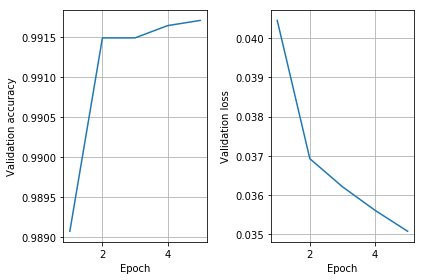

In [21]:
valAcc = history_cb.val_acc
valLoss = history_cb.val_loss
epoch_it = np.arange(1,6)
plt.subplot(121)
plt.plot(epoch_it, valAcc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.tight_layout()
plt.subplot(122)
plt.plot(epoch_it, valLoss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.tight_layout()
plt.show()

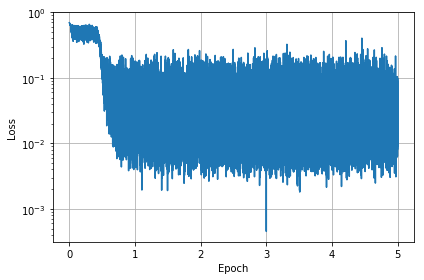

In [22]:
Ls = history_cb.losses
Acc = history_cb.accs
ntr = np.shape(x_train)[0]
epochNum = []
for i in range(18530):
    epochNum.append(i*100/ntr)

matplotlib.pyplot.semilogy(epochNum, Ls)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

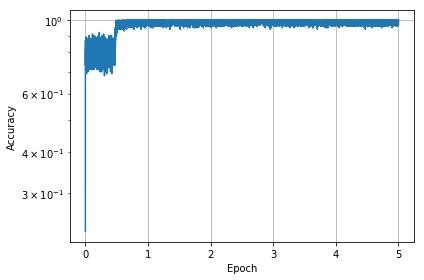

In [23]:
matplotlib.pyplot.semilogy(epochNum, Acc)
# plt.plot(epochNum, Acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
# plt.axis([0.3,3,0.96,1])
plt.show()


In [24]:
##################
#####details######
##################

In [25]:
from sklearn.metrics import classification_report,confusion_matrix

In [26]:
y_pred_whole = model.predict_classes(X_whole,verbose=1)
#print(y_pred_whole[:5])

4894816/4898431 [============================>.] - ETA: 0s

In [27]:
# yhat[yhat>0.5] = 1
# yhat[yhat<=0.5] = 0
count = 0
yhat_size = np.shape(y_pred_whole)[0]

for i in range (yhat_size):
    if y_pred_whole[i] != Y_whole[i]:
        count = count + 1
print("Accuracy is: %s" %(1-count/yhat_size))
print("# of wrongly classified: %s" %(count))

Accuracy is: 0.8005046922167527
# of wrongly classified: 977214


In [28]:
print(classification_report(Y_whole, y_pred_whole))

             precision    recall  f1-score   support

          0       0.45      0.02      0.04    972781
          1       0.80      0.99      0.89   3925650

avg / total       0.73      0.80      0.72   4898431



In [29]:
Cm = confusion_matrix(Y_whole,y_pred_whole)
C = np.sum(Cm)
Cm = Cm/C
print('Confusion Matrix:')
print(np.array_str(Cm, precision=4, suppress_small=True))

Confusion Matrix:
[[ 0.0042  0.1944]
 [ 0.0051  0.7963]]
